Ángulo observado entre los vectores de pendiente: 132.87460869436708 grados
Valor p de la prueba de permutación: 0.006


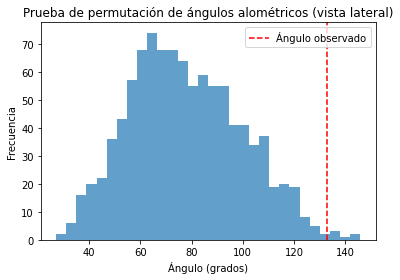

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import LabelEncoder

# SUPUESTOS:
# - Tienes un archivo CSV (por ejemplo, "landmarks_data.csv") con columnas:
#   specimen_id, group, x1, y1, x2, y2, ..., xN, yN, centroid_size
#   (donde 'group' indica el morfotipo, por ejemplo, "lamarcki" o "rouxi").
#
# Nota: Si no tienes centroid_size en el CSV, debe calcularse previamente.
#
# Cargar los datos:


def ordenar_puntos(puntos):
    """
    Ordena los puntos en base al ángulo polar respecto al centroide.
    Este método es adecuado para conjuntos de puntos que forman un polígono
    convexo o casi convexo.
    """
    # Calcular el centroide
    centroide = np.mean(puntos, axis=0)
    
    # Calcular el ángulo polar de cada punto respecto al centroide
    angulos = np.arctan2(puntos[:, 1] - centroide[1], puntos[:, 0] - centroide[0])
    
    # Obtener el índice de ordenamiento basado en el ángulo
    indices_orden = np.argsort(angulos)
    
    # Retornar los puntos ordenados
    return puntos[indices_orden]

# Cargar los dos CSV por separado
df1 = pd.read_csv("/storage/recol_conchas/zona_alta/lat/landmarks_data.csv")  # CSV del primer grupo
df2 = pd.read_csv("/storage/recol_conchas/zona_baja/lat/landmarks_data.csv")  # CSV del segundo grupo

# Agregar la columna "group" a cada DataFrame
df1["group"] = "zona_alta"  # o el nombre correspondiente al grupo 1
df2["group"] = "zona_baja"     # o el nombre correspondiente al grupo 2

# Combinar ambos DataFrames
df = pd.concat([df1, df2], ignore_index=True)

# (Opcional) Guardar el CSV combinado para su uso posterior
df.to_csv("landmarks_combinados.csv", index=False)



df = pd.read_csv("landmarks_combinados.csv")
# Extraer las columnas de forma: asumimos que las columnas de landmarks comienzan a partir de la tercera columna
# (las dos primeras son specimen_id y group)
# Extraer identificadores y grupo
specimen_ids = df["specimen_id"].values
groups = df["group"].values

landmark_cols = [col for col in df.columns if col not in ["specimen_id", "group"]]
shape_data = df[landmark_cols].values.astype(np.float64)  # forma (n_specimens, 2*N_landmarks)
N_landmarks = shape_data.shape[1] // 2  # Número total de landmarks


def calcular_centroide(puntos):
    # Si el polígono no está cerrado, lo cerramos
    if not np.array_equal(puntos[0], puntos[-1]):
        puntos = np.vstack([puntos, puntos[0]])
    
    area = 0.0
    Cx = 0.0
    Cy = 0.0
    n = len(puntos) - 1  # El último punto es el mismo que el primero
    
    # Cálculo del área y del centroide
    for i in range(n):
        x0, y0 = puntos[i]
        x1, y1 = puntos[i+1]
        factor = (x0 * y1 - x1 * y0)
        area += factor
        Cx += (x0 + x1) * factor
        Cy += (y0 + y1) * factor

    area = area / 2.0
    if area == 0:
        raise ValueError("El área del polígono es cero, la fórmula no es aplicable.")

    Cx = Cx / (6.0 * area)
    Cy = Cy / (6.0 * area)
    
    return Cx, Cy, puntos  # Devolvemos también el polígono cerrado


# 2) Calcular Centroid Size para cada configuración
def compute_centroid_size(vec, N):
    pts = vec.reshape(N, 2)
    centroid = pts.mean(axis=0)
    size = np.sqrt(np.sum((pts - centroid)**2))
    return size

cs = np.array([compute_centroid_size(vec, N_landmarks) for vec in shape_data])

# 3) Generalized Procrustes Analysis (GPA)
def generalized_procrustes_analysis(data_array, max_iter=50, tol=1e-7):
    aligned = data_array.copy().astype(np.float64)
    n = aligned.shape[0]
    n_points = aligned.shape[1] // 2
    def to_mat(vec):
        return vec.reshape(n_points, 2)
    
    # Normalizar cada configuración: centrar y escalar
    for i in range(n):
        mat = to_mat(aligned[i])
        mat -= mat.mean(axis=0)
        scale = np.sqrt((mat**2).sum())
        mat /= scale
        aligned[i] = mat.flatten()
        
    mean_shape = aligned.mean(axis=0)
    
    for iteration in range(max_iter):
        mat_mean = to_mat(mean_shape)
        mat_mean -= mat_mean.mean(axis=0)
        scale = np.sqrt((mat_mean**2).sum())
        mat_mean /= scale
        mean_shape = mat_mean.flatten()
        
        for i in range(n):
            mat = to_mat(aligned[i])
            mat -= mat.mean(axis=0)
            scale_i = np.sqrt((mat**2).sum())
            mat /= scale_i
            
            A = mat.T @ mat_mean.reshape(n_points,2)
            U, S, Vt = np.linalg.svd(A)
            R = U @ Vt
            mat_rot = mat @ R
            aligned[i] = mat_rot.flatten()
        
        new_mean = aligned.mean(axis=0)
        diff = np.linalg.norm(new_mean - mean_shape)
        mean_shape = new_mean
        if diff < tol:
            break
    return aligned, mean_shape

aligned, consensus = generalized_procrustes_analysis(shape_data)

# 4) Ajuste de regresión multivariada: para cada grupo, se ajusta el modelo
def regression_beta1(cs, shape):
    n = cs.shape[0]
    X = np.column_stack((np.ones(n), cs))
    Beta, _, _, _ = np.linalg.lstsq(X, shape, rcond=None)
    return Beta[1, :]  # La pendiente (Beta1)

beta_dict = {}
unique_groups = np.unique(groups)
for group in unique_groups:
    mask = (groups == group)
    beta1 = regression_beta1(cs[mask], aligned[mask])
    beta_dict[group] = beta1

# 5) Calcular el ángulo entre los vectores Beta1 de cada grupo
def angle_between(v1, v2):
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    cos_angle = np.clip(cos_angle, -1, 1)
    angle_rad = np.arccos(cos_angle)
    return np.degrees(angle_rad)

observed_angle = angle_between(beta_dict[unique_groups[0]], beta_dict[unique_groups[1]])
print("Ángulo observado entre los vectores de pendiente:", observed_angle, "grados")

# Prueba de permutación para evaluar la diferencia en la dirección alométrica
n_perm = 1000
perm_angles = []
n = len(groups)
for i in range(n_perm):
    permuted = np.random.permutation(groups)
    beta_perm = {}
    for grp in unique_groups:
        mask = (permuted == grp)
        if np.sum(mask) < 2:
            beta_perm[grp] = np.zeros(aligned.shape[1])
        else:
            beta_perm[grp] = regression_beta1(cs[mask], aligned[mask])
    angle_perm = angle_between(beta_perm[unique_groups[0]], beta_perm[unique_groups[1]])
    perm_angles.append(angle_perm)
perm_angles = np.array(perm_angles)

p_value = np.mean(perm_angles >= observed_angle)
print("Valor p de la prueba de permutación:", p_value)

plt.hist(perm_angles, bins=30, alpha=0.7)
plt.axvline(observed_angle, color='red', linestyle='--', label="Ángulo observado")
plt.xlabel("Ángulo (grados)")
plt.ylabel("Frecuencia")
plt.title("Prueba de permutación de ángulos alométricos (vista lateral)")
plt.legend()
plt.show()

In [121]:
shape_data = df[landmark_cols].values.astype(np.float64)  # forma (n_specimens, 2*N_landmarks)
N_landmarks = shape_data.shape[1] // 2  # Número total de landmarks
pts = shape_data[0].reshape(N_landmarks, 2)

pts

array([[   0.,   18.],
       [ 595.,  716.],
       [1264.,    0.],
       [1506.,   26.],
       [ 491.,  684.],
       [ 397.,  637.],
       [ 307.,  543.],
       [ 255.,  461.],
       [ 202.,  359.],
       [  44.,  107.],
       [ 395.,   15.],
       [ 789.,   46.],
       [1113.,   27.],
       [1349.,    5.],
       [1373.,  173.],
       [1288.,  254.],
       [1198.,  350.],
       [1103.,  459.],
       [1001.,  559.],
       [ 836.,  670.]])

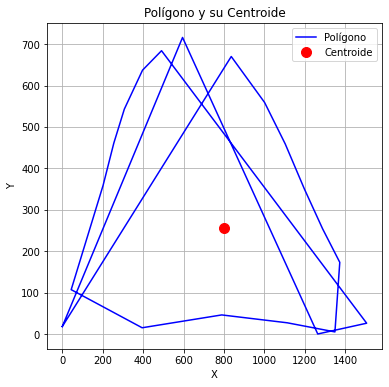

In [122]:
centroide_x, centroide_y, puntos_cerrado = calcular_centroide(pts)
# Graficamos el polígono
plt.figure(figsize=(6, 6))
plt.plot(puntos_cerrado[:, 0], puntos_cerrado[:, 1], 'b-', label="Polígono")

# Graficamos el centroide con un punto rojo más grande
plt.plot(centroide_x, centroide_y, 'ro', markersize=10, label="Centroide")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Polígono y su Centroide")
plt.legend()
plt.grid(True)
plt.show()


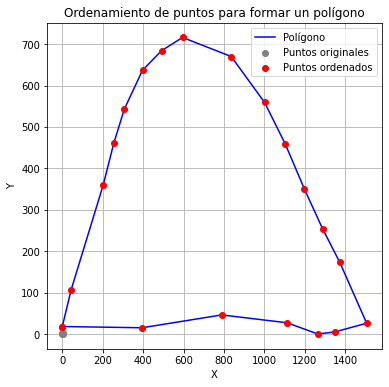

In [123]:
import numpy as np
import matplotlib.pyplot as plt



# Ejemplo de puntos (puedes cambiar este conjunto por el tuyo)

# Ordenar los puntos para formar el polígono
puntos_ordenados = ordenar_puntos(puntos_cerrado)

# Cerrar el polígono agregando el primer punto al final
puntos_poligono = np.vstack([puntos_ordenados, puntos_ordenados[0]])

# Graficar los puntos y el polígono resultante
plt.figure(figsize=(6, 6))
plt.plot(puntos_poligono[:, 0], puntos_poligono[:, 1], 'b-', label='Polígono')
plt.scatter(puntos[:, 0], puntos[:, 1], color='gray', zorder=5, label='Puntos originales')
plt.scatter(puntos_ordenados[:, 0], puntos_ordenados[:, 1], color='red', zorder=10, label='Puntos ordenados')
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Ordenamiento de puntos para formar un polígono")
plt.legend()
plt.grid(True)
plt.show()


In [111]:
landmark_cols = df[df['specimen_id'] == 'LanZbPV27.JPG'].drop(['specimen_id', 'group'], axis=1)
# Inicializamos las listas
lista_x = []
lista_y = []

# Recorremos la fila: cada par (nombre columna, valor)
for columna, valor in landmark_cols.items():
    if 'x' in columna.lower():  # Usamos lower() por si el nombre tiene mayúsculas
        lista_x.append(int(valor))
    elif 'y' in columna.lower():
        lista_y.append(int(valor))

In [110]:
int(valor)

451

No handles with labels found to put in legend.


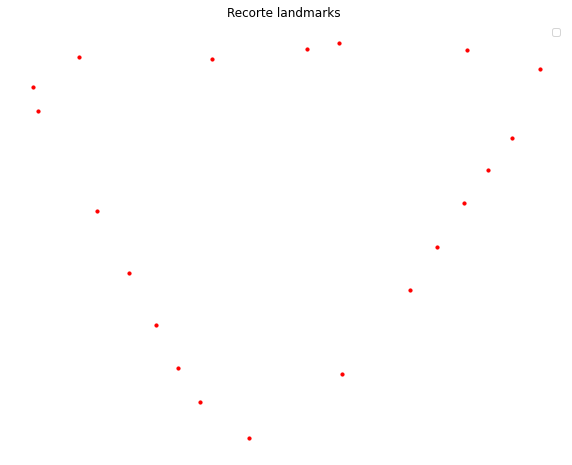

In [118]:
#landmark_cols = df.columns.difference(["specimen_id", "group"])
#shape_data = df[landmark_cols].values.astype(np.float64) 
#pts = shape_data[0].reshape(20, 2)
plt.figure(figsize=(10, 8))
plt.scatter(lista_x, lista_y, c='red', s=10)
plt.title(f"Recorte landmarks ")
plt.axis('off')
plt.legend()
plt.grid(True)
plt.show()
